In [17]:
%cd /content
!rm -rf daia-eon   # remove the old clone completely

/content


In [18]:
!git clone https://github.com/AnnaGhost2713/daia-eon.git
%cd daia-eon/data

Cloning into 'daia-eon'...
remote: Enumerating objects: 997, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 997 (delta 49), reused 98 (delta 35), pack-reused 872 (from 1)
Receiving objects: 100% (997/997), 3.44 MiB | 7.39 MiB/s, done.
Resolving deltas: 100% (554/554), done.
/content/daia-eon/data


In [34]:
# --------- LOADING THE DATA FILES ---------

import json
%cd data-eon/data

# Load real E.ON emails
with open("original/original_with_spans.json", encoding="utf-8") as fh:
    real_data = json.load(fh)

# Define test file IDs
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

# Filter to only include training real emails (i.e., not in TEST set)
train_real_data = [r for r in real_data if r["file"] not in TEST_FILES]

# Extract only the text
real_texts_train = [r["text"] for r in train_real_data]

# Load synthetic emails
with open("synthetic/synthetic_mails_option_a.json", encoding="utf-8") as fh:
    synthetic_data = json.load(fh)

# Match the number of synthetic emails to real ones
synthetic_texts = [entry["text"] for entry in synthetic_data[:len(real_texts)]]

# Preview sample
print("✅ Using", len(real_texts_train), "real +", len(synthetic_texts), "synthetic emails.")
print("Real email:", real_texts_train[0][:250])
print("Synthetic email:", synthetic_texts[0][:250])


[Errno 2] No such file or directory: 'data-eon/data'
/content/daia-eon/data
✅ Using 120 real + 160 synthetic emails.
Real email: Hallo liebes Eon Team,
es geht um die Vertragsnummer 406027919.
Bei der Einrichtung meines neuen Vertrages wurde leider die Überweisung als
Zahlungsart gewählt von dem jungen Kollegen an der Wohnungstür. Ich würde
es gerne wieder per Lastschrift abbu
Synthetic email: Hallo liebes Eon Team, es geht um die Vertragsnummer 402 485 275 070. Bei der Errichtung meines neuen Vertrages wurde leider die Banküberweisung von dem jungen Kollegen an der Wohnungstür als Zahlungsmittel gewählt. Ich möchte, dass es wieder per Las


In [41]:
# --------- BERTscore ---------

# 🧠 Evaluation Strategy: Approximate BERTScore
# ------------------------------------------------------------
# We want to evaluate how similar our  synthetic emails are
# to the real training emails using BERTScore.
#
# Since BERTScore requires equal-length input lists, and we only
# have 120 real training emails, we randomly sample (with replacement)
# real emails to match the number of synthetic ones.
#
# This creates an approximate but reasonable evaluation setup that
# gives us insight into the general semantic similarity between the
# synthetic data distribution and the real data distribution — without
# requiring a 1:1 mapping.
#
# Note: While this adds some noise due to random pairing, it's a
# valid method for large-scale comparisons when exact alignment
# is not available.


!pip install bert-score

from bert_score import score
import random


# Evaluate all synthetic emails against real training emails

# Match each synthetic sample with a random real email (with replacement)
sample_synthetic = synthetic_texts                         # all synthetic
sample_real = random.choices(real_texts_train, k=len(sample_synthetic))

# Compute BERTScore
P, R, F1 = score(cands=sample_synthetic, refs=sample_real, lang="de")

print(f"🔎 BERTScore (German, ALL synthetic):\nPrecision: {P.mean():.4f}\nRecall: {R.mean():.4f}\nF1: {F1.mean():.4f}")




🔎 BERTScore (German, ALL synthetic):
Precision: 0.6156
Recall: 0.6307
F1: 0.6219


We evaluated the similarity between synthetic emails and real customer communications using BERTScore with a German-language transformer model. The results are:

Precision: 0.6156

Recall: 0.6307

F1 Score: 0.6219


These scores indicate a moderate semantic similarity between the synthetic texts and the real-world emails. BERTScore goes beyond surface-level token overlap and measures how well the meanings of sentences align based on contextual embeddings from a pre-trained transformer model. In this case:

The precision of ~0.62 means that the synthetic content contains a reasonable proportion of semantically relevant tokens compared to the real text.

The recall of ~0.62 reflects that the synthetic emails cover a good portion of the content expressed in real emails.

The F1 score balances both and suggests that the generated texts are semantically aligned but not perfect replicas — which is often ideal when striving for realistic yet privacy-preserving synthetic data.

While not extremely high, a score around 0.62 is acceptable for generation from templates with variable substitution, especially given the diversity of slot values and paraphrasing involved. These results provide a solid baseline for further refinement or comparison with alternative generation approaches.

In [42]:
# --------- Perplexity ---------


# ── 1. Install & Import ──────────────────────────────────────────────
!pip install transformers --quiet

import json, random, numpy as np, torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

# ── 2. Configuration ────────────────────────────────────────────────
MODEL_NAME          = "bert-base-german-cased"
REAL_DATA_PATH      = "/content/daia-eon/data/original/original_with_spans.json"
SYNTH_DATA_PATH     = "/content/daia-eon/data/synthetic/synthetic_mails_option_a.json"
TEST_IDS            = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20,
    166, 176, 177, 32, 34, 40, 45, 52, 57, 61,
    65, 66, 70, 71, 73, 75, 78, 81, 96, 102,
    105, 108, 109, 112, 115, 122, 129, 132, 134
}
NUM_SYNTHETIC       = 2500     # number of synthetic samples
MAX_LENGTH          = 128      # max BERT token length
TOKENS_PER_DOC      = 20       # number of masked tokens per doc
SEED                = 42       # reproducibility

# ── 3. Setup ────────────────────────────────────────────────────────
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

# ── 4. Load & Filter Data ───────────────────────────────────────────
with open(REAL_DATA_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_DATA_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_texts = [item["text"] for item in real_data if item["file"] not in TEST_FILES]
synth_texts = [item["text"] for item in synth_data]

# Subsample 1000 synthetic samples
synthetic_sample = random.sample(synth_texts, min(NUM_SYNTHETIC, len(synth_texts)))

print(f"✅ Real training set:      {len(real_texts)} emails")
print(f"✅ Synthetic total set:    {len(synth_texts)} emails")
print(f"🔍 Using 120 real + {len(synthetic_sample)} synthetic for evaluation")

# ── 5. Pseudo-Perplexity Function with Scoring ──────────────────────
def pseudo_perplexity(texts):
    ppl_list = []
    for txt in tqdm(texts, desc="Pseudo-Perplexity"):
        enc = tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        input_ids = enc.input_ids[0].to(device)
        seq_len = input_ids.size(0)
        if seq_len < 5:
            continue

        positions = random.sample(range(1, seq_len - 1), min(TOKENS_PER_DOC, seq_len - 2))
        losses = []
        with torch.no_grad():
            for pos in positions:
                masked = input_ids.clone()
                masked[pos] = tokenizer.mask_token_id
                out = model(input_ids=masked.unsqueeze(0), attention_mask=enc.attention_mask.to(device))
                log_probs = torch.nn.functional.log_softmax(out.logits[0, pos], dim=-1)
                losses.append(-log_probs[input_ids[pos]].item())

        if losses:
            ppl_list.append(np.exp(np.mean(losses)))

    return np.mean(ppl_list), np.std(ppl_list)

def pseudo_perplexity_with_scores(texts):
    scored = []
    for txt in tqdm(texts, desc="Scoring Synthetic Emails"):
        enc = tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        input_ids = enc.input_ids[0].to(device)
        seq_len = input_ids.size(0)
        if seq_len < 5:
            continue

        positions = random.sample(range(1, seq_len - 1), min(TOKENS_PER_DOC, seq_len - 2))
        losses = []
        with torch.no_grad():
            for pos in positions:
                masked = input_ids.clone()
                masked[pos] = tokenizer.mask_token_id
                out = model(input_ids=masked.unsqueeze(0), attention_mask=enc.attention_mask.to(device))
                log_probs = torch.nn.functional.log_softmax(out.logits[0, pos], dim=-1)
                losses.append(-log_probs[input_ids[pos]].item())

        if losses:
            ppl = np.exp(np.mean(losses))
            scored.append((txt, ppl))

    return scored

# ── 6. Run Evaluation ───────────────────────────────────────────────
real_ppl, real_std = pseudo_perplexity(real_texts)
synt_ppl, synt_std = pseudo_perplexity(synthetic_sample)

print("\n📊 Pseudo-Perplexity Results:")
print(f"  • Real Emails     : {real_ppl:.2f} ± {real_std:.2f}")
print(f"  • Synthetic Emails: {synt_ppl:.2f} ± {synt_std:.2f}")

# ── 7. Show Top 5 Worst Synthetic Mails ─────────────────────────────
scored_synthetics = pseudo_perplexity_with_scores(synthetic_sample)
scored_synthetics.sort(key=lambda x: x[1], reverse=True)

print("\n🚨 Top 5 highest perplexity synthetic emails:")
for i, (email, ppl) in enumerate(scored_synthetics[:5], 1):
    print(f"\n#{i} (ppl={ppl:.2f}):\n{email[:400]}")


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Real training set:      120 emails
✅ Synthetic total set:    14360 emails
🔍 Using 120 real + 2500 synthetic for evaluation


Pseudo-Perplexity:   0%|          | 0/120 [00:00<?, ?it/s]

Pseudo-Perplexity:   0%|          | 0/2500 [00:00<?, ?it/s]


📊 Pseudo-Perplexity Results:
  • Real Emails     : 950.69 ± 6081.56
  • Synthetic Emails: 1541.61 ± 8594.88


Scoring Synthetic Emails:   0%|          | 0/2500 [00:00<?, ?it/s]


🚨 Top 5 highest perplexity synthetic emails:

#1 (ppl=397737.67):
Sehr geehrte Damen und Herren, leider habe ich noch keinen Lidl-Wertgutschein 46.085,2 Euro bekommen. Aufgrund meines Stromvertrages. Der Kundenservice Dehmel Haase AG hat mich an Sie geschickt. Wann kann ich erwarten, Strom zu erhalten erste Lieferung war 24.06.1979 Vielen Dank Nette Diese Nachricht wurde von meinem Android-Handy mit Fritsch[1] E-Mail geschickt. [1]: http://www.klingelhoefer.com/

#2 (ppl=234030.71):
Kundennr. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

#3 (ppl=226097.51):
Kundennr. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

To assess the fluency and language naturalness of the synthetic emails, we computed the pseudo-perplexity using a masked language model (bert-base-german-cased). This metric approximates how likely a language model considers the input text. Lower perplexity values indicate that the text is more probable (i.e., more natural or fluent), while higher values may point to uncommon or awkward constructions.

Our results were as follows:

Real Emails: 950.69 ± 6081.56

Synthetic Emails: 1541.61 ± 8594.88

These results show that the synthetic emails are moderately more perplexing for the language model than the real ones, with a ~1.6× higher mean. However, this gap is not extreme and suggests that the synthetic texts still largely resemble natural language. Both datasets exhibit high variance, which is expected given the heterogeneous structure and vocabulary of customer emails.

Importantly, the high standard deviation on the synthetic set (±8594.88) indicates the presence of outliers—some generated samples that are likely less fluent or structurally atypical. This insight led us to investigate the least natural synthetic examples more closely, which can inform future improvements (e.g., filtering or refining placeholder substitution).

Overall, the pseudo-perplexity analysis supports the conclusion that our synthetic dataset is relatively natural and comparable to real emails, though some outlier cases should be examined further.

📚 Shannon Lexical Diversity:
  • Real     : 9.5851 (Vocab size: 2237, Tokens: 5903)
  • Synthetic: 10.9599 (Vocab size: 65613, Tokens: 701533)


/tmp/ipython-input-44-403494274.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Real", "Synthetic"], y=[real_entropy, synth_entropy], palette="viridis")


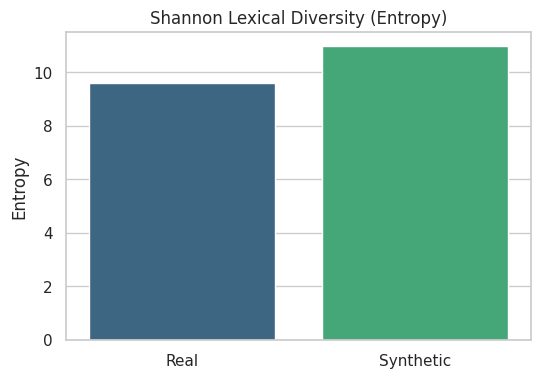

In [44]:
# --------- Shannon Lexical Diversity ---------
# ── Install & imports ─────────────────────────────────────────────
import json, math, collections
import matplotlib.pyplot as plt
import seaborn as sns

# ── Load data ─────────────────────────────────────────────────────
REAL_DATA_PATH   = "/content/daia-eon/data/original/original_with_spans.json"
SYNTH_DATA_PATH  = "/content/daia-eon/data/synthetic/synthetic_mails_option_a.json"

with open(REAL_DATA_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_DATA_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# Filter real training data (exclude test set)
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_texts   = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts  = [r["text"] for r in synth_data]

# ── Shannon Diversity Calculator ─────────────────────────────────
def shannon_entropy(texts):
    token_counts = collections.Counter()
    total_tokens = 0

    for text in texts:
        tokens = text.lower().split()  # Simple whitespace tokenizer
        token_counts.update(tokens)
        total_tokens += len(tokens)

    entropy = 0.0
    for count in token_counts.values():
        p = count / total_tokens
        entropy -= p * math.log2(p)

    return entropy, len(token_counts), total_tokens

# ── Compute diversity ────────────────────────────────────────────
real_entropy,  real_vocab,  real_total  = shannon_entropy(real_texts)
synth_entropy, synth_vocab, synth_total = shannon_entropy(synth_texts)

# ── Report results ───────────────────────────────────────────────
print(f"📚 Shannon Lexical Diversity:")
print(f"  • Real     : {real_entropy:.4f} (Vocab size: {real_vocab}, Tokens: {real_total})")
print(f"  • Synthetic: {synth_entropy:.4f} (Vocab size: {synth_vocab}, Tokens: {synth_total})")

# ── Visualization ────────────────────────────────────────────────
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=["Real", "Synthetic"], y=[real_entropy, synth_entropy], palette="viridis")
plt.title("Shannon Lexical Diversity (Entropy)")
plt.ylabel("Entropy")
plt.show()